# MLflow quickstart: training and logging  

This tutorial is based on the MLflow [ElasticNet Diabetes example](https://github.com/mlflow/mlflow/tree/master/examples/sklearn_elasticnet_diabetes). It illustrates how to use MLflow to track the model training process, including logging model parameters, metrics, the model itself, and other artifacts like plots. It also includes instructions for viewing the logged results in the MLflow tracking UI.    

This notebook uses the scikit-learn `diabetes` dataset and predicts the progression metric (a quantitative measure of disease progression after one year) based on BMI, blood pressure, and other measurements. It uses the scikit-learn ElasticNet linear regression model, varying the `alpha` and `l1_ratio` parameters for tuning. For more information on ElasticNet, refer to:
  * [Elastic net regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization)
  * [Regularization and Variable Selection via the Elastic Net](https://web.stanford.edu/~hastie/TALKS/enet_talk.pdf)

### Note
This notebook was originally published as a [Databricks Notebook](https://community.cloud.databricks.com/?o=3797818470089835#notebook/3246829711022031/command/3246829711022032). Click the link for more details.

## Import required libraries and load dataset

In [1]:
# Import required libraries
import os
import warnings
import sys

import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

# Import mlflow
import mlflow
import mlflow.sklearn

# Load diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Create pandas DataFrame 
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'progression']
data = pd.DataFrame(d, columns=cols)

#Set SQLite backend for MLflow to guarantee Model Registry support
import os
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name = "elastic_net_experiment")

2023/01/22 20:08:11 INFO mlflow.tracking.fluent: Experiment with name 'elastic_net_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='elastic_net_experiment', tags={}>

## Create function to plot ElasticNet descent path
The `plot_enet_descent_path()` function:
* Creates and saves a plot of the [ElasticNet Descent Path](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html) for the ElasticNet model for the specified *l1_ratio*.
* Returns an image that can be displayed in the notebook using `display()`
* Saves the figure `ElasticNet-paths.png` to the cluster driver node

In [2]:
def plot_enet_descent_path(X, y, l1_ratio):
    # Compute paths
    eps = 5e-3  # the smaller it is the longer is the path

    # Reference the global image variable
    global image
    
    print("Computing regularization path using ElasticNet.")
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio)

    # Display results
    fig = plt.figure(1)
    ax = plt.gca()

    colors = cycle(['b', 'r', 'g', 'c', 'k'])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    for coef_e, c in zip(coefs_enet, colors):
        l1 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

    plt.xlabel('-Log(alpha)')
    plt.ylabel('coefficients')
    title = 'ElasticNet Path by alpha for l1_ratio = ' + str(l1_ratio)
    plt.title(title)
    plt.axis('tight')

    # Display images
    image = fig
    
    # Save figure
    fig.savefig("ElasticNet-paths.png")

    # Close plot
    plt.close(fig)

    # Return images
    return image    

## Train the diabetes model
The `train_diabetes()` function trains ElasticNet linear regression based on the input parameters *in_alpha* and *in_l1_ratio*.

The function uses MLflow Tracking to record the following:
* parameters
* metrics
* model
* the image created by the `plot_enet_descent_path()` function defined previously.

**Tip:** Databricks recommends using `with mlflow.start_run:` to create a new MLflow run. The `with` context closes the MLflow run regardless of whether the code completes successfully or exits with an error, and you do not have to call `mlflow.end_run`.

In [3]:
# train_diabetes
#   Uses the sklearn Diabetes dataset to predict diabetes progression using ElasticNet
#       The predicted "progression" column is a quantitative measure of disease progression one year after baseline
#       http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html
def train_diabetes(data, in_alpha, in_l1_ratio):
  
  # Evaluate metrics
  def eval_metrics(actual, pred):
      rmse = np.sqrt(mean_squared_error(actual, pred))
      mae = mean_absolute_error(actual, pred)
      r2 = r2_score(actual, pred)
      return rmse, mae, r2

  warnings.filterwarnings("ignore")
  np.random.seed(40)

  # Split the data into training and test sets. (0.75, 0.25) split.
  train, test = train_test_split(data)

  # The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
  train_x = train.drop(["progression"], axis=1)
  test_x = test.drop(["progression"], axis=1)
  train_y = train[["progression"]]
  test_y = test[["progression"]]

  if float(in_alpha) is None:
    alpha = 0.05
  else:
    alpha = float(in_alpha)
    
  if float(in_l1_ratio) is None:
    l1_ratio = 0.05
  else:
    l1_ratio = float(in_l1_ratio)
  
  # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
  with mlflow.start_run(run_name = "my_run"):
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    # Print out ElasticNet model metrics
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    # Log mlflow attributes for mlflow UI
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    mlflow.sklearn.log_model(lr, "model")
    
    # Call plot_enet_descent_path
    image = plot_enet_descent_path(X, y, l1_ratio)
    
    # Log artifacts (output files)
    mlflow.log_artifact("ElasticNet-paths.png")
        

## Experiment with different parameters

Call `train_diabetes` with different parameters. You can visualize all these runs in the MLflow experiment.

In [4]:
# alpha and l1_ratio values of 0.01, 0.01
train_diabetes(data, 0.01, 0.01)

Elasticnet model (alpha=0.010000, l1_ratio=0.010000):
  RMSE: 71.40362571026475
  MAE: 60.09124839565383
  R2: 0.2291130640003659
Computing regularization path using ElasticNet.


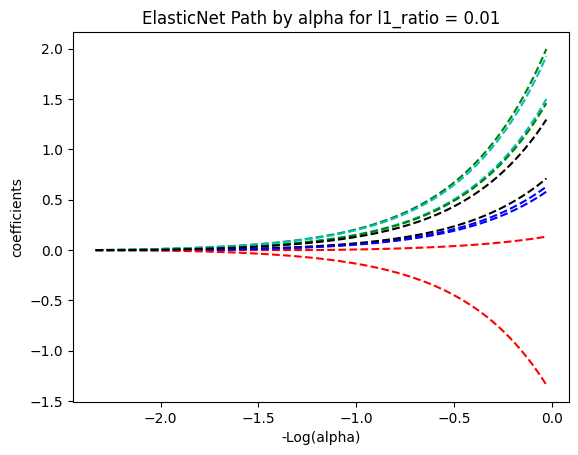

In [5]:
display(image)

In [6]:
# alpha and l1_ratio values of 0.01, 0.75
train_diabetes(data, 0.01, 0.75)

Elasticnet model (alpha=0.010000, l1_ratio=0.750000):
  RMSE: 65.28994906390733
  MAE: 53.75914828434926
  R2: 0.35547047607749416
Computing regularization path using ElasticNet.


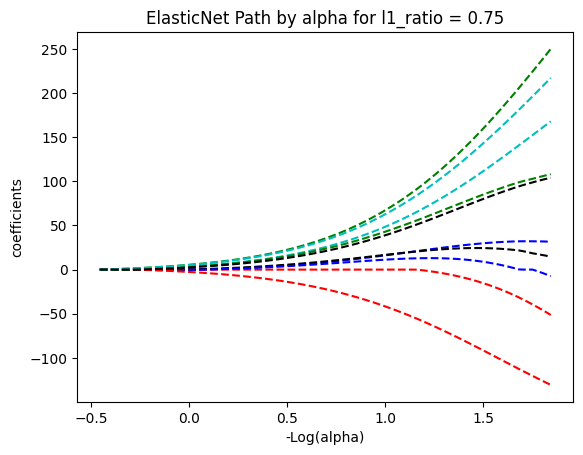

In [7]:
display(image)

In [8]:
# alpha and l1_ratio values of 0.01, .5
train_diabetes(data, 0.01, .5)

Elasticnet model (alpha=0.010000, l1_ratio=0.500000):
  RMSE: 67.98354871814037
  MAE: 56.73838604280737
  R2: 0.30119208073981796
Computing regularization path using ElasticNet.


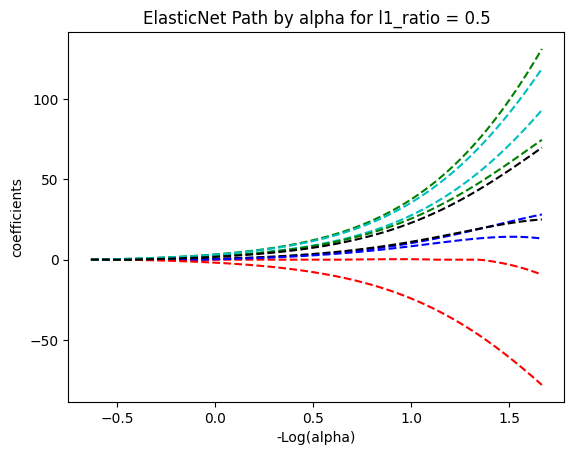

In [9]:
display(image)

In [10]:
# alpha and l1_ratio values of 0.01, 1
train_diabetes(data, 0.01, 1)

Elasticnet model (alpha=0.010000, l1_ratio=1.000000):
  RMSE: 63.24666777876805
  MAE: 51.05182860408632
  R2: 0.3951809598912357
Computing regularization path using ElasticNet.


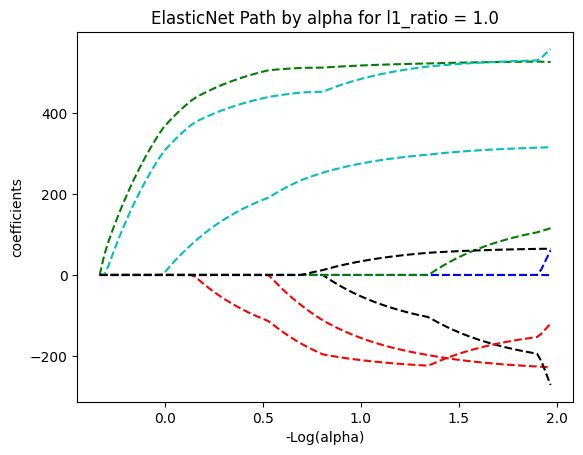

In [11]:
display(image)